# EEG Dataset Processing Pipeline

Scope:
- Process a raw EEG dataset 
- Dataset containing the results of an EEG study on multiple subjects
- Dataset that has been downloaded from OpenNeuro, and structured as per the BIDS standard, and in EEGLab '.set' format

The Pipeline Stages (For each subject in an EEG study dataset):
- EEG Dataset Load - Get the raw source EEG signal data
- EEG Preprocessing - Execute filtering etc of the raw EEG time series data
- Power Spectra (PSD) Calculate - Calculate the power spectra, for all channels recorded
- Spectral Parameterisation - Determine the best fitting Aperiodic and Periodic components
- Features Set - Collate & save the study, subject and EEG data into a features set, Pandas Dataframe


## To Review

Projects:
- Perplexity project: https://www.perplexity.ai/search/i-am-building-a-pipeline-in-py-sVmw70rHQXa0VKkIT_p5tg?0=r
- Python Handbook: https://github.com/ZitongLu1996/Python-EEG-Handbook/tree/master
- Pickle: https://www.perplexity.ai/search/in-a-jupyter-notebook-i-have-c-0LbAAH9ITFGfcPYaWlrt6Q

## Dependencies

General dependencies:
- python = 3.11.13
- numpy = 2.0.2
- scipy = 1.15.3
- pandas = 2.2.3
- matplotlib = 3.10.3

ML dependencies:
- scikit-learn = 1.6.1

EEG specific dependencies:
- mne = 1.9.0
- specparam = 2.0.0rc3

## Python-MNE

Used for Import:
- MNE-Python: https://mne.tools/stable/index.html
- The Brain Imaging Data Structure (BIDS): https://bids.neuroimaging.io

Used for Power Spectrum Calculate
- MNE vs NeuroDSP: https://www.perplexity.ai/search/using-python-which-package-is-zOoiPqUvTnKbO.QfgmPsJQ

Formats:
- Assumes OpenNeuro, BIDS compliant datasets manually downloaded into the defined folders structure
- Assumes EEGLab '.set' format


## Spectral Parameterisation

Spectral Parameterisation:
- The Aperiodic Methods project - Documentation: https://aperiodicmethods.github.io/docs/index.html and Repo: in https://github.com/AperiodicMethods/AperiodicMethods
- And cite: https://www.biorxiv.org/content/10.1101/2024.09.15.613114v1

Documentation:
- SpecParam: https://specparam-tools.github.io and https://github.com/fooof-tools
- FOOOF: https://fooof-tools.github.io/fooof/ and https://github.com/fooof-tools/fooof

FOOOF vs SpecPram:
- FOOOF: More stable and used but deprecated
- SpecParam: Release candidate but some improved model/fit selection: https://pmc.ncbi.nlm.nih.gov/articles/PMC11326208/
- Summary: https://www.perplexity.ai/search/using-python-which-package-is-M7kzhERoTLuCrIKbXxN9sQ


# Imports & Utilities

In [1]:
# Not availble through a Conda install/environment - PIP Install may be required
# %pip install specparam


In [2]:
# General imports
import os
import gc
from datetime import datetime
from pprint import pprint

import math
import numpy as np
import pandas as pd

# Plots
import matplotlib.pyplot as plt
plt.style.use('ggplot')

# MNE-Python
import mne

# SpecParam
from specparam import SpectralGroupModel
from specparam.plts.spectra import plot_spectra

# Check the version of SpecParam
from specparam import __version__ as specparam_version
print('Current SpecParam version:', specparam_version)

Current SpecParam version: 2.0.0rc3


In [3]:
# A utility function to establish relative paths for a given folder
def get_folder_path(folder_name):
    project_root = os.path.dirname(os.getcwd())
    folder_path = os.path.join(project_root, folder_name)
    if not os.path.isdir(folder_path):
        raise FileNotFoundError(f'Directory not found: {folder_path}')  
     
    return folder_path

# Utility function to check for the existence of a file in a given directory
def get_file_path(folder, file_name):
    file_path = os.path.join(folder, file_name)
    if not os.path.isfile(file_path):
        raise FileNotFoundError(f'File not found: {file_path}')
    return file_path


# Classes & Functions

## EEG_Study Class

In [4]:
# Class defining the paraemters for an EEG study

class EEG_Study:
    """
    Defintion and parameters for an EEG study

    Attributes
    ----------
    study_run_id : str
    subjects_df : dataframe of subjects in study
    psd_parames : parameters for power spectra / PSD calculation
    """

    # Data Folders
    __eeg_datasets_source_folder = 'Data/EEG_Datasets_Source_exgithub'
    __eeg_study_features_folder = 'Data/EEG_Datasets_Processed'

    # BIDS structure, file name for source of subjects data
    __subjects_source_file = 'participants.tsv'

    def __init__(self, dataset_name, psd_params, specparam_params):
        """
        Initialise EEG_Study instance.

        Parameters
        ----------
        dataset_name : str
        psd_params : dic
        specparam_params : dic

        Returns
        -------
        Study : class instance
        """

        # Input validation - Valid Folder paths
        eeg_datasets_folder_path = get_folder_path(self.__eeg_datasets_source_folder)
        eeg_study_features_folder_path = get_folder_path(self.__eeg_study_features_folder)

        # Input validation - Valid Dataset
        datasets_list = os.listdir(eeg_datasets_folder_path)
        datasets_list = [d for d in datasets_list if d.startswith('ds') and os.path.isdir(os.path.join(eeg_datasets_folder_path, d))]

        if dataset_name not in datasets_list:
            raise ValueError(f"Dataset '{dataset_name}' not found in list of available datasets: {datasets_list}")
        dataset_path = os.path.join(eeg_datasets_folder_path, dataset_name)
        if not os.path.exists(dataset_path):
            raise FileNotFoundError(f"Path does not exist: {dataset_path}")
        subjects_file = os.path.join(eeg_datasets_folder_path, dataset_name, self.__subjects_source_file)
        if not os.path.isfile(subjects_file):
            raise FileNotFoundError(f'File not found: {subjects_file}')
        
        # Create ID / Name for the study run
        current_date = datetime.now().strftime('%Y%m%d')
        study_run_id = f'{dataset_name}_{current_date}'
        
        # Private Attributes
        # TODO: Any private attributes?

        # Public Attributes
        self.study_run_id = study_run_id
        self.dataset_path = dataset_path
        self.psd_params = psd_params
        self.specparam_params = specparam_params
        self.subjects_df = self._create_subjects_df(subjects_file)

    # Private functions

    def _create_subjects_df(self, subjects_csv):
        # Read the datset csv file to get selected subjects data
        try:
            temp_subjects_df = pd.read_csv(subjects_csv, sep='\t')
        except Exception as e:
            raise IOError(f"Failed to read subjects file '{subjects_csv}': {e}")
        subjects_df = temp_subjects_df[['participant_id', 'AGE', 'GENDER', 'TYPE']].copy()
        subjects_df.columns = ['subject_id', 'age', 'gender', 'pd']

        return subjects_df
    
    # Public functions
    



## Get Raw EEG data

In [5]:
# Function to get the raw EEG signal data
def get_EEG_raw(study, subject_id):
    """
    Get raw EEG data.

    Parameters
    ----------
    study : Study class
    subject_id : str

    Returns
    -------
    EEG_raw : raw
    """
    
    # BIDS File Structure
    # dataset_root = 
    # dataset_name = 
    subject = subject_id
    session = ''
    task = 'Rest'
    datatype='eeg'

    # EEGLab .set file name
    temp_path = os.path.join(study.dataset_path, subject, session, datatype)
    temp_file_name = subject + '_task-' + task + '_' + datatype + '.set'
    eeg_lab_file_path = get_file_path(temp_path, temp_file_name)

    # Get the raw EEG data
    if 'VERBOSE' in globals() and VERBOSE:
        mne.set_log_level('DEBUG')
    else:
        mne.set_log_level('WARNING')

    try:
        eeg_dataset_raw = mne.io.read_raw_eeglab(eeg_lab_file_path, preload=True)
    except Exception as e:
        raise ValueError(f"Failed to load EEG data for subject {subject}: {e}") 
    
    if 'VERBOSE' in globals() and VERBOSE:
        print(f"EEG Raw Data Obtained: {eeg_dataset_raw.info['description']} on {eeg_dataset_raw.info['meas_date']}")
        print(eeg_dataset_raw)
        print(eeg_dataset_raw.info)

        # TODO: Add plots

    return eeg_dataset_raw

## EEG Preprocessing

In [6]:
# Function to preprocess the raw EEG signal data
def perform_EEG_preprocessing(study, EEG_raw):
    """
    Preprocessing of the EEG raw data

    Parameters
    ----------
    study : Study class
    EEG_raw : raw

    Returns
    -------
    EEG_clean : clean
    """

    print(f'TO DO - Preprocess of raw EEG')

    # TODO: Add filtering
    # TODO: Add ICA
    # TODO: Subject 68 had 66 channels but max should be 63? Check during preprocessing, before FOOOFING

    if 'VERBOSE' in globals() and VERBOSE:
        print('To Do: Preprocessing results ....')

    EEG_clean = EEG_raw

    return EEG_clean


## Get the Power Spectra

In [7]:
# Function to get the power spectra from the cleaned/preprocessed EEG signal data
def get_spectra(study, EEG_clean):
    """
    Obtain the Power Spectra for all channels

    Parameters
    ----------
    study : Study class
    EEG_clean : clean

    Returns
    -------
    Spectra : frequencies and powers for each channel
    """

    try:
        spectra_result = EEG_clean.compute_psd(method=study.psd_params['method'],
                                               fmin=study.psd_params['fmin'],
                                               fmax=study.psd_params['fmax'],
                                               exclude=study.psd_params['exclude'])
    except Exception as e:
        raise Exception(f"Error calculating spectra: {e}")

    if 'VERBOSE' in globals() and VERBOSE:
        print(f'Spectra computed using parameters: {study.psd_params}')
        print(spectra_result)
        print(spectra_result.info)

        # freqs = spectra_result.freqs
        # powers = spectra_result.get_data(return_freqs=False)
        # n_channels = powers.shape[0]
        # # n_channels = len(spectra_result.ch_names)
        # n_frequencies = powers.shape[1]
        # freq_resolution = freqs[1] - freqs[0]
        # print(f'Spectra Group:')
        # print(f'- {n_channels} channels & {n_frequencies} frequencies')
        # print(f'- Frequency Range: {freqs.min():.1f} to {freqs.max():.1f} Hz')
        # print(f'- Frequency resolution {freq_resolution:.2f} Hz')

        # TODO: Add plots

    return spectra_result


## Spectral Parameterisation

In [8]:
# Function to perform Spectral Parameterisation and dtermine the aperiodic and periodic components
def perform_SpecParam(study, spectra):
    """
    Spectral Parameterisation to determine the aperiodic and periodic components for all channels

    Parameters
    ----------
    study : Study class
    spectra : spectra

    Returns
    -------
    SpecParam.df : dataframe of components for each channel
    """

    # Initialise SpecParam Group Model & fit it
    freqs = spectra.freqs
    powers = spectra.get_data(return_freqs=False)

    spm_fit_freq_range = [1, 75]

    try:
        fg = SpectralGroupModel(peak_width_limits=study.specparam_params['peak_width_limits'], 
                                max_n_peaks=study.specparam_params['max_n_peaks'], 
                                min_peak_height=study.specparam_params['min_peak_height'],
                                peak_threshold=study.specparam_params['peak_threshold'],
                                aperiodic_mode=study.specparam_params['aperiodic_mode'])
        fg.fit(freqs, powers, study.specparam_params['fit_freq_range'], progress='tqdm.notebook')
    except Exception as e:
        raise Exception(f"Error performing SpecParam: {e}")

    specparam_df = fg.to_df(10)        

    if 'VERBOSE' in globals() and VERBOSE:
        print(f'With parameters: {study.specparam_params}')
        print(f'Executed Settings: {fg.get_settings()}')
        # Overall group results
        fg.print_results()

        # TODO: Add plots
        fg.plot()
        plt.show()

    return specparam_df



# Execute Full EEG Pipeline - Single Dataset

In [9]:
# Define the execution parameters
#

# Set progress messages, testing
VERBOSE = True
max_subjects_run = 1 #np.inf
test_channel = 'P5'

# Set Execution Parameters
psd_params = {'method': 'welch', # Calculation method
              'fmin': 1,         
              'fmax': 250,       
              'exclude': []      # Includes all, even bad channels
              }
specparam_params = {'peak_width_limits': [1, 12],
                    'max_n_peaks': 10,
                    'min_peak_height': 0.1,
                    'peak_threshold': 2.0,
                    'aperiodic_mode': 'fixed',
                    'fit_freq_range' : [1, 75]
                    }

# Define the Study
study_details = EEG_Study('ds004584-1.0.0', psd_params, specparam_params)

# print(study_details)
# attrs = {attr: getattr(study_details, attr) for attr in dir(study_details) if not attr.startswith('_') and not callable(getattr(study_details, attr))}
# pprint(attrs)





-----------------------------------------------------------------------------------------------
Processing subject: sub-001

----------------------------------------------
Getting EEG raw data
Reading /Users/stuartgow/GitHub/EEG_ML_Pipeline/Data/EEG_Datasets_Source_exgithub/ds004584-1.0.0/sub-001/eeg/sub-001_task-Rest_eeg.fdt
Reading 0 ... 140829  =      0.000 ...   281.658 secs...
Cropping annotations 1970-01-01 00:00:00+00:00 - 1970-01-01 00:04:41.660000+00:00
  [0] Keeping  (1970-01-01 00:00:00+00:00 - 1970-01-01 00:00:00+00:00 -> 0.0 - 0.0)
Cropping complete (kept 1)
EEG Raw Data Obtained: None on None
<RawEEGLAB | sub-001_task-Rest_eeg.fdt, 63 x 140830 (281.7 s), ~67.8 MiB, data loaded>
<Info | 8 non-empty values
 bads: []
 ch_names: Fp1, Fz, F3, F7, FT9, FC5, FC1, C3, T7, TP9, CP5, CP1, P3, P7, ...
 chs: 63 EEG
 custom_ref_applied: False
 dig: 66 items (3 Cardinal, 63 EEG)
 highpass: 0.0 Hz
 lowpass: 250.0 Hz
 meas_date: unspecified
 nchan: 63
 projs: []
 sfreq: 500.0 Hz
>

----

/var/folders/wd/rhzj_w8570g_y66t6j6mh4zw0000gn/T/ipykernel_45595/345241518.py:36: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  eeg_dataset_raw = mne.io.read_raw_eeglab(eeg_lab_file_path, preload=True)


Running group fits.:   0%|          | 0/63 [00:00<?, ?it/s]

With parameters: {'peak_width_limits': [1, 12], 'max_n_peaks': 10, 'min_peak_height': 0.1, 'peak_threshold': 2.0, 'aperiodic_mode': 'fixed', 'fit_freq_range': [1, 75]}
Executed Settings: ModelSettings(peak_width_limits=[1, 12], max_n_peaks=10, min_peak_height=0.1, peak_threshold=2.0, aperiodic_mode='fixed')
                                                                                                  
                                          GROUP RESULTS                                           
                                                                                                  
                             Number of power spectra in the Group: 63                             
                                                                                                  
                        The model was run on the frequency range 1 - 75 Hz                        
                                 Frequency Resolution is 0.24 Hz                                 

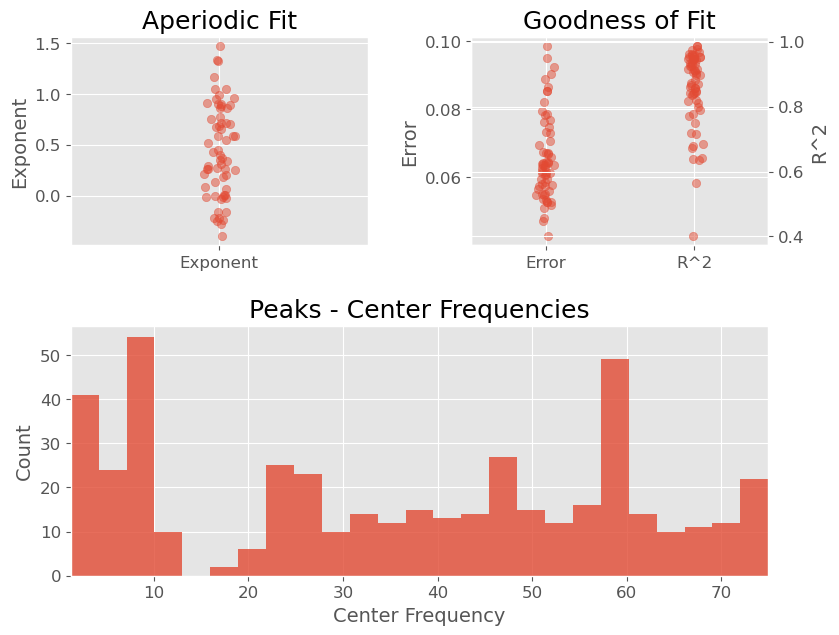

In [ ]:
# Run the pipeline for each subject in the study
#

for idx, subject in study_details.subjects_df.iterrows():
    # Break for testing
    if int(idx) > (max_subjects_run - 1):
        break

    subject_id = subject['subject_id']
    print('\n-----------------------------------------------------------------------------------------------')
    print(f"Processing subject: {subject_id}")

    # Get the raw EEG data
    print('\n----------------------------------------------')
    print('Getting EEG raw data')
    temp_EEG_raw = get_EEG_raw(study_details, subject_id)

    # EEG Preprocessing
    print('\n----------------------------------------------')
    print('Preprocessing EEG')
    temp_EEG_clean = perform_EEG_preprocessing(study_details, temp_EEG_raw)

    # Power spectrum
    print('\n----------------------------------------------')
    print('Getting power spectra')
    temp_spectra = get_spectra(study_details, temp_EEG_clean)

    # Spectral Parameterisation
    print('\n----------------------------------------------')
    print('Completing Spectral Parameterisation')
    specparam_df = perform_SpecParam(study_details, temp_spectra)

    # TODO: Subject 68 had 66 channels but max should be 63? Check during preprocessing, before FOOOFING
    # if n_channels > spm_max_channels:
    #     raise Exception(f'WARNING: Found: {n_channels} channels, but only {spm_max_channels} max are saved')
